In [1]:
%run stdPackages.ipynb

# A Basic Model of the Electricity System

In this exercise, we'll consider a basic model of the electricity system. In **Q1**, we solve a very simple model using pen and paper methods. In **Q2** we implement a simple numerical version of this, setting up the appropriate structure to solve it using the ```scipy.optimize.linprog``` method.

## Q1. Characterize Model

Consider a stylized, static model of the electricity wholesale market where a portfolio of different dispatchable generators (indexed by $i$) competes to serve a fixed load $L$ MWh. Let $E_i$ denote the generated electricity by generator $i$ measured in MWh and $q_i$ the installed hourly generating capacity in MW. The generators use a combination of primary energy carriers (indexed by $j$) and an aggregate of other inputs ($oth$). Let $\mu_j^i$ denote the input share of energy carrier $j$ for generator $i$ -- i.e. MWh input of energy carrier $j$ per MWh electricity output. Let $p_j^f$ denote the price of carrier $j$ measured in €/MWh. The use of primary carriers ($j$) is tied to \CO2 emissions in fixed ratios.

### **Q1.1: Briefly explain the optimization problem in equations (1).**
$\begin{align}
    \min \ \sum_i& c_i E_i \tag{1a} \\
    \text{subject to }L&=\sum_i E_i \tag{1b} \\ 
    c_i &= c_i^{oth}+\sum_j\mu_j^i p_j^f, \qquad \forall i \tag{1c}\\ 
    E_i &\in[0, q_i], \qquad \forall i. \tag{1d}
\end{align}$

**Answer**

(1a): Electricity production cost minimization problem

(1b): Constraint representing the requirement that the production of electricity should exactly match the demand of electricity.

(1c): Variable costs for each energy plant i, consisting of the costs of aggregate of other inputs (c_i^{oth}) and the sum of costs associated with the production of one MWh of electricity by plant i with energy carrier j

(1d): Constraint representing the requirement of electricity production from any plant to be feasible, ensuring non-negativity and production within the respective plant's capacity.

### **Q1.2:**

*Let $\phi_j$ denote the emission intensity of energy carrier $j$ measured in ton CO2/MWh. Assume that we have an estimate of the social cost of carbon of $p_{CO2}$ €/ton CO2.*


*Briefly explain the problem in equations (2). What does the new parameter $v_i$ measure?*
\begin{align}
    \min \ \sum_i& \left(c_i+v_i\cdot p_{CO2}\right) E_i \tag{2a}\\
    \text{subject to }L&=\sum_i E_i \tag{2b} \\ 
    v_i &= \sum_j\mu_j^i\phi_j \tag{2c} \\
    E_i &\in[0, q_i], \qquad \forall i. \tag{2d}
\end{align}

**Answer**

(2a): Electricity production cost minimization problem. Costs now consist of marginal production costs and costs originating from the CO2 externality.

(2b): Constraint representing the requirement that the production of electricity should exactly match the demand of electricity.

(2c): CO2 emissions per MWh of production in tonnes of CO2 for each plant i using energy carrier j.

(2d): Constraint representing the requirement of electricity production from any plant to be feasible, ensuring non-negativity and production within the respective plants capacity.

### **Q1.3**
*Derive the first order conditions for the problem in (2b). Give a brief interpretation.*

**Answer**

\begin{equation}
    \mathbf{L} = - \sum_i (c_i + v_i \cdot p_{CO2}) E_i + \lambda ( \sum_i E_i - L) + \sum_i \bar{\theta_i} (q_i - E_i) + \sum_i \underline{\theta_i} \cdot E_i \tag{3}
\end{equation}

The first order conditions for the problem in (2b) are derived through the maximisation of (3) and given as:

\begin{align}
    \frac{\delta \mathbf{L}}{\delta E_i} &= - ( c_i + v_i \cdot P_{CO2} ) + \lambda - \bar{\theta_i} + \underline{\theta_i} = 0 \tag{3a} \\
    \bar{\theta_i} ( q_i - E_i ) &= 0; \qquad \bar{\theta_i} \geq 0; \qquad q_i - E_i \geq 0 \tag{3b} \\
    \underline{\theta_i} E_i &= 0; \qquad \underline{\theta_i} \geq 0; \qquad E_i \geq 0 \tag{3c}
\end{align}

And can be interpreted as follows: 

(3a) represents the requirement of $E_i$ being a local optimum. 

(3b) determines the feasible values of the first shadow variable $\bar{\theta_i}$, which can be interpreted as the savings in equilibrium from a unit-increase in the production cap $q_i$ of plant $i$. 

(3c) determines the feasible values of the second shadow variable $\underline{\theta_i}$, which can be interpreted as the required equilibrium price increase in order to merit the start of usage of power from plant $i$.


### **Q1.4. Merit order curve and solution**

The file *PS3\_Q1_tables.xlsx* includes a small dataset with three generators. Tables 1-2 translates the names used in the data to the symbols used in the model above. 

| **Table 1: Symbols Dictionary** | |
| --- | --- |
| *Name in excel data* | *Model Symbol* |
| FuelMix | $\mu_j^i$ |
| EmissionIntensity | $\phi_j$ |
|FuelPrice | $p_j^f$ |
| EmissionTax | $p_{CO2}$ |
| Load | $L$ |
| GeneratingCapacity | $q_i$ |
| OtherMC | $c_i^{oth}$ |

| **Table 2: Index Dictionary** | |
| --- | --- |
| *Name in excel data* | *Model Index* |
| BFt | $j$ |
| id | $i$ |

*The following uses the package ```pyDbs``` to load and arrange the data in a simple key,value like database. It has a few methods that reads in symbols from excel and add them as pandas series with the appropriate pandas indices. This is what we use here to read in the data:*

In [2]:
import pyDbs
db = pyDbs.read.dbFromWB(os.path.join(d['data'], 'PS3_Q1.xlsx'),
                        {'variables': ['Fundamentals','Load','Generator'],
                         'variable2D': ['FuelMix'],
                         'maps': ['GeneratorCategories']})
pyDbs.readSets(db) # this method adds indices from the declared symbols to the database.

*This database stores symbols in ```self.symbols```; you can get the symbols using simple 'slicing' syntax, e.g. the index for plants:*

*Based on this small dataset, draw the merit-order curve and compute the solution for $E_i$ and $\lambda$.*

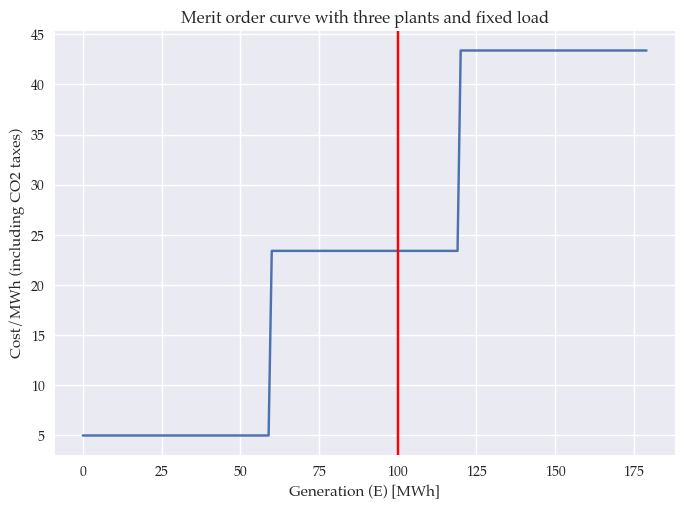

In [3]:
# marginal costs ci (per MWh of energy generated) without regulation
db['MC'] = db['OtherMC'] + (db['FuelMix']*db['FuelPrice']).groupby(level='id').sum()

# amount of pollution per MWh of energy generated for each plant, i.e. marginal emissions
db['ME'] = (db['FuelMix']*db['EmissionIntensity']).groupby(level='id').sum()

# total marginal costs (per MWh of energy generated) without regulation
db['TotalMC'] = db['MC']

# sort by cost
TotalMC_sorted = db['TotalMC'].sort_values().index

# total marginal social costs (per MWh of energy generated)
db['SocialMC'] = db['MC'] + (db['ME']*db['EmissionTax']['CO2'])

# Generating values for x axis
mwh = pd.Index(np.arange(0, db['GeneratingCapacity']['A'] + db['GeneratingCapacity']['B'] + db['GeneratingCapacity']['C']))
# Extracting the values for y axis (note the +1 in the definition of smc_C is to )
smc_A = pd.Series([db['SocialMC']['A']]*db['GeneratingCapacity']['A'])
smc_B = pd.Series([db['SocialMC']['B']]*db['GeneratingCapacity']['B'])
smc_C = pd.Series([db['SocialMC']['C']]*(db['GeneratingCapacity']['C']))
# Putting x and y axis together in a dataFrame
mo_df = pd.concat([smc_C, smc_A, smc_B])
mo_df.index = mwh

# Generating the merit order curve for the case with taxation
mo_df.plot()
plt.axvline(db['Load']['Consumer 1'], 0, round(max(db['TotalMC'])+10), color='red')
plt.xlabel('Generation (E) [MWh]')
plt.ylabel('Cost/MWh (including CO2 taxes)')
plt.title('Merit order curve with three plants and fixed load')
plt.grid(True)
plt.show()

## solution for optimal production for each plant (E_i) and shadow price of the equilibrium constraint

# since plant A is the second cheapest plant and plant A + plant C (which is the cheapest plant) have a combined production capacity of 120 (60 each) increasing the load by one marginal unit will increase the system costs by exactly the costs of producing one more unit of energy with plant A.
λ = db['TotalMC']['A']

# MC of plant C < λ -> E_C = q_C
E_C = db['GeneratingCapacity']['C']

# MC of plant A = λ -> E_A = L - q_C
E_A = db['Load']['Consumer 1'] - db['GeneratingCapacity']['C']

# MC of plant B > λ -> E_B = 0
E_B = 0

### **Q1.5. A Cap on Emissions**

Assume that, instead of having a price on CO2 emissions $(p_{CO2})$, we implement a cap on CO2 emissions as follows:
\begin{align}
    \sum_i v_i\cdot E_i \leq \overline{CO2}. \tag{4}
\end{align}
*Adjust the Lagrange in (3) appropriately and derive the first order conditions again.*

\begin{equation}
    \mathbf{L}' = - \sum_i c_i \cdot E_i + \lambda ( \sum_i E_i - L) + \sum_i \bar{\theta_i} (q_i - E_i) + \sum_i \underline{\theta_i} \cdot E_i + \theta^{CO2} (\overline{CO2} - \sum_i v_i \cdot E_i )    \tag{4a}
\end{equation}

The first order conditions for the problem as described are derived through the maximisation of (4a) and given as:

\begin{align}
    \frac{\delta \mathbf{L}'}{\delta E_i} &= - c_i + \lambda - \bar{\theta_i} + \underline{\theta_i} - v_i \cdot \theta^{CO2} = 0 \tag{4b} \\
    \bar{\theta_i} ( q_i - E_i ) &= 0; \qquad \bar{\theta_i} \geq 0; \qquad q_i - E_i \geq 0 \tag{4c} \\
    \underline{\theta_i} E_i &= 0; \qquad \underline{\theta_i} \geq 0; \qquad E_i \geq 0 \tag{4d} \\
    \theta^{CO2} (\overline{CO2} - \sum_i v_i \cdot E_i) &= 0; \qquad \theta^{CO2} \geq 0; \qquad \overline{CO2} - \sum_i v_i \cdot E_i \geq 0 \tag{4e}
\end{align}

Here, constraint (4) is incorporated in the original optimisation as described in equations (1) in a normal manner.

### **Q1.6. Interpretation of shadow variable $\theta^{CO2}$**

In **Q1.4** we used a price on CO2 emissions of 5€. This resulted in roughly 27.2 tonnes of CO2 emissions in optimum. Now, in the emissions cap scenario (**Q1.5**), let $\theta^{CO2}$ denote the shadow cost of the constraint in (4) and assume that we fix the cap at $\overline{CO2}=25$ tonnes instead. 


*Give an interpretation of what $\theta^{CO2}$ measures. Based on the small data set, what is the value in this model with $\overline{CO2}=25$?*

$\theta^{CO2}$ measures the savings caused by a unit increase in $\overline{CO2}$, at equilibrium equivalent to an increase of $\overline{CO2}$ from 25 to 26 tonnes. This can be shown by deriving the derivative of $\mathbf{L}$ with respect to $\overline{CO2}$ as follows:

\begin{equation}
    \frac{\delta \mathbf{L}'}{\delta \overline{CO2}} = \theta^{CO2}
\end{equation}

This can further be verified by considering equations (4e), which can be interpreted as $\theta^{CO2}$ being positive only if the cap on CO2 emissions is actually met in optimium and always zero if the cap is not reached and the amount of CO2 emissions that minimize costs lie below the cap. \\

Based on the small data set, $\theta^{CO2} = 79.2$ in equilibrium with $\overline{CO2} = 25$. 

For the equilibrium and emission cap constraints: $\sum_i E_i = L = 100$ while $\sum_i v_i * E_i ≤ 25$ to hold, we produce 60MWh with plant C. Because the cost minimizing production of the remaining 40MWh of electricity with plant B would produce to much CO2-emissions, we have to generate some of the electricity with plant B. Raising the emission cap allows again for more production with plant A which would decrease costs. See the following code for the derivation of $\theta^{CO2}$

In [4]:
# Deriving θCO2 = 79.2$
# E_A + E_B + E_C = 100 (1) and (v_A*E_A) + (v_B*E_B) + (v_C*E_C) ≤ CO2 (2) need to hold
# Since v_C = 0 and c_C < c_A < c_B we produce the first q_C = 60MWh with plant C
# This then leaves: E_A + E_B = 40 (1) and (v_A*E_A) + (v_B*E_B) ≤ CO2 (2)
# Rewriting gives: E_A = (40 - (CO2/v_B))/(1 - (v_A/v_B)) and E_B = (CO2 - (v_A*E_A))/v_B
# Inserting values with CO2 = 25

E_A_CO2_25 = (40 - (25/db['ME']['B']))/(1 - (db['ME']['A']/db['ME']['B']))
E_B_CO2_25 = (25 - (db['ME']['A']*E_A_CO2_25))/db['ME']['B']

c_A_CO2_25 = E_A_CO2_25*db['MC']['A']
c_B_CO2_25 = E_B_CO2_25*db['MC']['B']

# Inserting values with CO2 = 26

E_A_CO2_26 = (40 - (26/db['ME']['B']))/(1 - (db['ME']['A']/db['ME']['B']))
E_B_CO2_26 = (26 - (db['ME']['A']*E_A_CO2_26))/db['ME']['B']

c_A_CO2_26 = E_A_CO2_26*db['MC']['A']
c_B_CO2_26 = E_B_CO2_26*db['MC']['B']

# Calculating the difference in costs

theta_CO2 = (c_A_CO2_25 + c_B_CO2_25) - (c_A_CO2_26 + c_B_CO2_26)

## Q2. Numerical implementation

The algorithm in ```scipy.optimize.linprog``` solves what we will refer to as an "augmented form" of the linear program (as opposed to the "standard form" that does not feature explicit equality constraints):

$$\begin{align} 
    &\min_{x} \ c^T\cdot x \tag{5a}\\ 
    &A_{ub}\times x \leq b_{ub} \tag{5b}\\ 
    &A_{eq}\times x  = b_{eq} \tag{5c}\\ 
    &l\leq x\leq u, \tag{5d}
\end{align}$$
where: 
* $x$ is the vector of choice variables of length ($N$).
* $c, l, u$ are coefficient vectors of the same length ($N$).
* $b_{eq}, b_{ub}$ are coefficient vectors of lengths $N_{eq}, N_{ub}$, 
* and $A_{eq}, A_{ub}$ are coefficient matrices of sizes $(N_{eq}\times N)$ and $(N_{ub} \times N)$ respectively.

We will generally refer to the inequality constraints $l\leq x \leq u$ as *domain constraints*, whereas the constraints that combine multiple variables as *variational constraints* (1B-1C). 

At its core, the ```scipy.optimize.linprog``` takes inputs in the form of arrays (e.g. ```np.arrays```), which means that we have to be careful with the ordering of variables and constraints: The $n$'th element in $c$ represents the same element as the $n$'th elements in $l,u$ and the $n$'th column vectors in $A_{ub}, A_{eq}$. Thus, when solving a model with many different types of constraints and variables, the task of constructing suitable vectors / matrices becomes quite cumbersome. In the simple model from **Q1**, however, it is very simple.

### **Q2.1. Set up relevant vectors and matrices for the model in Q1.3. Solve it numerically.**

*Hint: You need to create relevant components (```c```, ```b_eq```, ```A_eq```, ```l```, ```u```) and then call*

```python
optimize.linprog(c, A_eq = A_eq, b_eq = b_eq, bounds = np.vstack([l, u]).T)
```

In [5]:
c = np.array(db['SocialMC'])
b_eq = np.array([100])
A_eq = np.array([[1]*3])
l = np.array([0]*3)
u = np.array([60]*3)
result = optimize.linprog(c, A_eq = A_eq, b_eq = b_eq, bounds = np.vstack([l, u]).T)
if result.success:
    print("Optimal generation levels:", result.x)
    print("Optimal total cost:", result.fun)

Optimal generation levels: [40.  0. 60.]
Optimal total cost: 1236.2819167208515


### **Q2.2. Add the emission cap from (4) with $\overline{CO2} = 25$ to the model and solve.**

In [6]:
c = np.array(db['TotalMC'])
b_eq = np.array([100])
A_eq = np.array([[1]*3])
b_ub = np.array([25])
A_ub = np.array([db['ME']])
l = np.array([0]*3)
u = np.array([60]*3)
result = optimize.linprog(c, A_eq = A_eq, b_eq = b_eq, A_ub = A_ub, b_ub = b_ub, bounds = np.vstack([l, u]).T)
if result.success:
    print("Optimal generation levels:", result.x)
    print("Optimal total cost:", result.fun)

Optimal generation levels: [31.90319032  8.09680968 60.        ]
Optimal total cost: 1273.0391058234395
